# 07 - Encoder-Decoder com LSTM

Neste notebook, vamos implementar um modelo encoder-decoder simples usando LSTM para tradução. Esta arquitetura é fundamental para muitas tarefas de processamento de linguagem natural e representa um marco importante no desenvolvimento de sistemas de tradução automática.

## Objetivos de Aprendizado
- Compreender a arquitetura encoder-decoder
- Implementar LSTM para codificação e decodificação de sequências
- Criar um modelo de tradução português-inglês
- Visualizar o processo de aprendizado
- Avaliar a qualidade das traduções
- Entender as limitações e possíveis melhorias

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import re
from collections import Counter

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

# Configurar seeds para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Dispositivo utilizado: cpu


## 1. Fundamentos Teóricos

### Arquitetura Encoder-Decoder

A arquitetura encoder-decoder consiste em dois componentes principais:

**1. Encoder (Codificador):**
- Processa a sequência de entrada $\mathbf{x} = (x_1, x_2, ..., x_T)$
- Produz uma representação de contexto fixo $\mathbf{c}$
- Matematicamente: $\mathbf{h}_t^{enc} = f_{enc}(\mathbf{x}_t, \mathbf{h}_{t-1}^{enc})$
- O contexto final: $\mathbf{c} = \mathbf{h}_T^{enc}$

**2. Decoder (Decodificador):**
- Gera a sequência de saída $\mathbf{y} = (y_1, y_2, ..., y_{T'})$
- Usa o contexto $\mathbf{c}$ como estado inicial
- Matematicamente: $\mathbf{h}_t^{dec} = f_{dec}(\mathbf{y}_{t-1}, \mathbf{h}_{t-1}^{dec})$
- Probabilidade de saída: $P(y_t | y_1, ..., y_{t-1}, \mathbf{c}) = \text{softmax}(\mathbf{W}_o \mathbf{h}_t^{dec} + \mathbf{b}_o)$

## 2. Preparação dos Dados

Vamos criar um conjunto de dados simples para tradução português-inglês, focando em estruturas gramaticais básicas:

In [2]:
# Dataset expandido de tradução português-inglês
translation_pairs = [
    # Frases básicas com pronomes
    ('eu sou estudante', 'i am student'),
    ('ele gosta de livros', 'he likes books'),
    ('ela come uma maçã', 'she eats an apple'),
    ('nós vamos à escola', 'we go to school'),
    ('eles têm um carro', 'they have a car'),
    ('você é inteligente', 'you are smart'),

    # Ações cotidianas
    ('eu bebo água', 'i drink water'),
    ('ele lê um jornal', 'he reads a newspaper'),
    ('ela escreve uma carta', 'she writes a letter'),
    ('nós estudamos matemática', 'we study mathematics'),
    ('eles jogam futebol', 'they play football'),
    ('você trabalha muito', 'you work hard'),

    # Descrições e estados
    ('eu moro aqui', 'i live here'),
    ('ele canta bem', 'he sings well'),
    ('ela dança bonito', 'she dances beautifully'),
    ('nós somos felizes', 'we are happy'),
    ('eles estão cansados', 'they are tired'),
    ('você fala português', 'you speak portuguese'),

    # Frases com objetos
    ('eu tenho um gato', 'i have a cat'),
    ('ele compra pão', 'he buys bread'),
    ('ela vê um filme', 'she watches a movie'),
    ('nós ouvimos música', 'we listen to music'),
    ('eles fazem comida', 'they make food'),
    ('você quer café', 'you want coffee')
]

print(f'Dataset criado com {len(translation_pairs)} pares de tradução')
print('\nExemplos de tradução:')
for i, (pt, en) in enumerate(translation_pairs[:5]):
    print(f'{i+1:2d}. PT: "{pt}" → EN: "{en}"')

Dataset criado com 24 pares de tradução

Exemplos de tradução:
 1. PT: "eu sou estudante" → EN: "i am student"
 2. PT: "ele gosta de livros" → EN: "he likes books"
 3. PT: "ela come uma maçã" → EN: "she eats an apple"
 4. PT: "nós vamos à escola" → EN: "we go to school"
 5. PT: "eles têm um carro" → EN: "they have a car"


In [3]:
class Vocabulary:
    """Classe para gerenciar vocabulário e conversões palavra-índice"""

    def __init__(self, name):
        self.name = name
        self.word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.word_count = {}
        self.n_words = 4

    def add_sentence(self, sentence):
        """Adiciona todas as palavras de uma frase ao vocabulário"""
        for word in sentence.strip().lower().split():
            self.add_word(word)

    def add_word(self, word):
        """Adiciona uma palavra ao vocabulário"""
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

    def sentence_to_indices(self, sentence):
        """Converte uma frase em uma lista de índices"""
        return [self.word2idx.get(word.lower(), self.word2idx['<UNK>'])
                for word in sentence.strip().split()]

    def indices_to_sentence(self, indices):
        """Converte uma lista de índices de volta para uma frase"""
        words = []
        for idx in indices:
            if idx == self.word2idx['<EOS>']:
                break
            if idx != self.word2idx['<PAD>']:
                words.append(self.idx2word[idx])
        return ' '.join(words)

# Criar vocabulários para português e inglês
pt_vocab = Vocabulary('português')
en_vocab = Vocabulary('inglês')

# Construir vocabulários a partir dos dados
for pt_sentence, en_sentence in translation_pairs:
    pt_vocab.add_sentence(pt_sentence)
    en_vocab.add_sentence(en_sentence)

print(f'Vocabulário português: {pt_vocab.n_words} palavras únicas')
print(f'Vocabulário inglês: {en_vocab.n_words} palavras únicas')
print(f'\nPalavras mais frequentes em português: {sorted(pt_vocab.word_count.items(), key=lambda x: x[1], reverse=True)[:10]}')
print(f'Palavras mais frequentes em inglês: {sorted(en_vocab.word_count.items(), key=lambda x: x[1], reverse=True)[:10]}')

Vocabulário português: 62 palavras únicas
Vocabulário inglês: 58 palavras únicas

Palavras mais frequentes em português: [('eu', 4), ('ele', 4), ('ela', 4), ('nós', 4), ('eles', 4), ('um', 4), ('você', 4), ('uma', 2), ('sou', 1), ('estudante', 1)]
Palavras mais frequentes em inglês: [('a', 5), ('i', 4), ('he', 4), ('she', 4), ('we', 4), ('they', 4), ('you', 4), ('are', 3), ('to', 2), ('have', 2)]


## 3. Visualização dos Dados

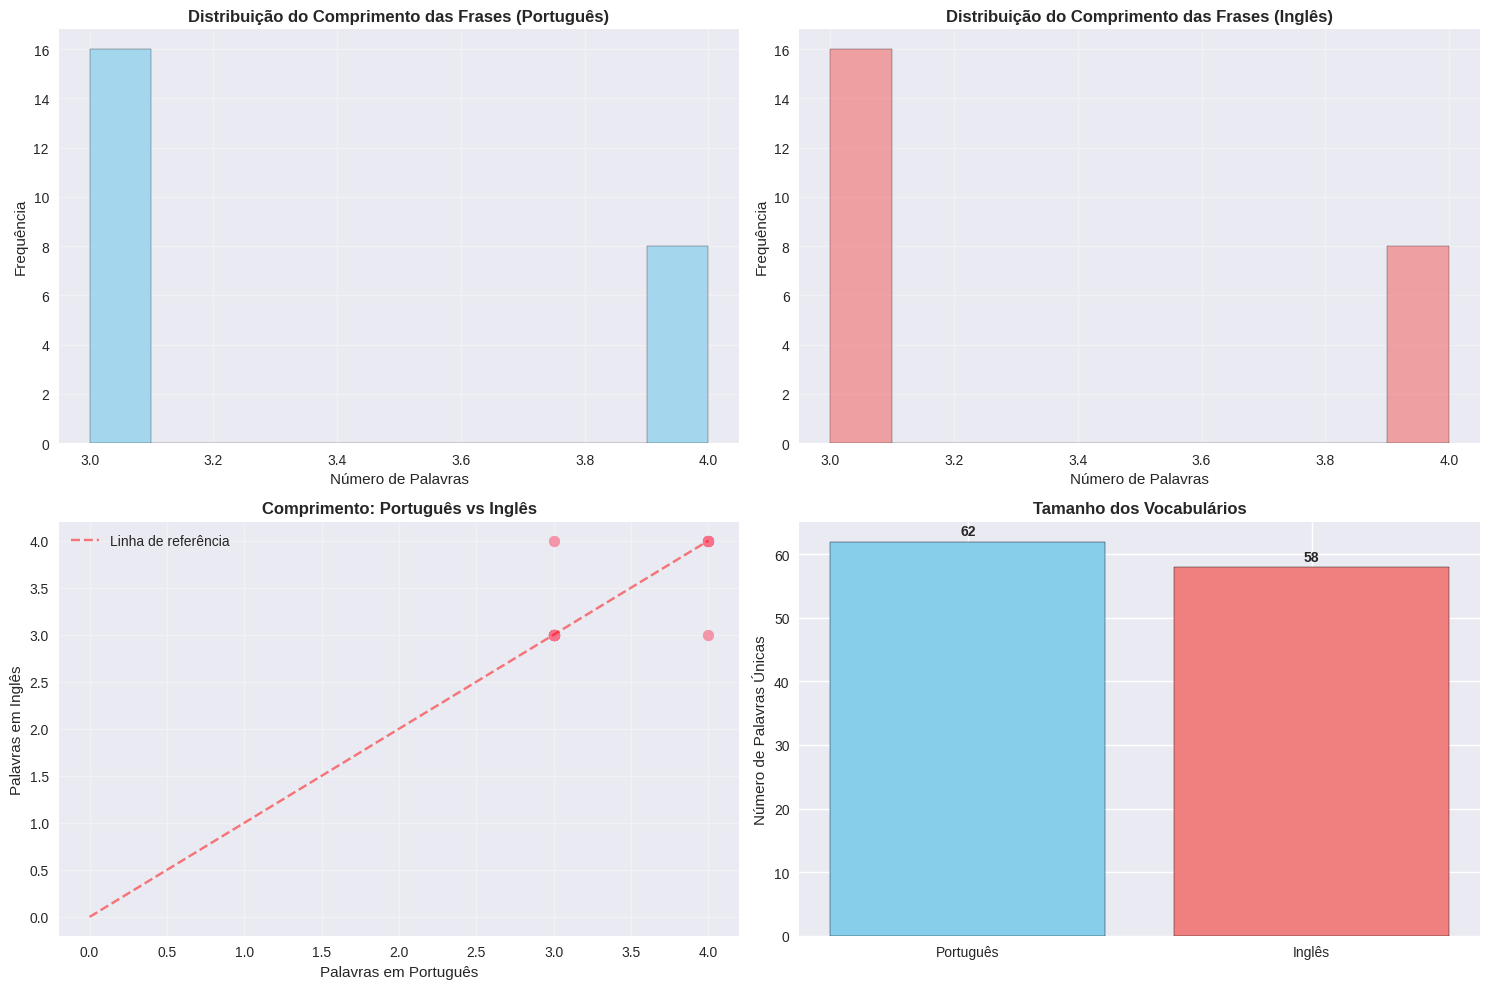

Estatísticas das frases:
Português - Média: 3.3 palavras, Max: 4, Min: 3
Inglês - Média: 3.3 palavras, Max: 4, Min: 3


In [4]:
# Análise estatística dos dados
pt_lengths = [len(pt.split()) for pt, _ in translation_pairs]
en_lengths = [len(en.split()) for _, en in translation_pairs]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribuição de comprimentos das frases
axes[0, 0].hist(pt_lengths, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição do Comprimento das Frases (Português)', fontweight='bold')
axes[0, 0].set_xlabel('Número de Palavras')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(en_lengths, bins=10, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribuição do Comprimento das Frases (Inglês)', fontweight='bold')
axes[0, 1].set_xlabel('Número de Palavras')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].grid(True, alpha=0.3)

# Comparação de comprimentos
axes[1, 0].scatter(pt_lengths, en_lengths, alpha=0.7, s=60)
axes[1, 0].plot([0, max(max(pt_lengths), max(en_lengths))], [0, max(max(pt_lengths), max(en_lengths))],
               'r--', alpha=0.5, label='Linha de referência')
axes[1, 0].set_title('Comprimento: Português vs Inglês', fontweight='bold')
axes[1, 0].set_xlabel('Palavras em Português')
axes[1, 0].set_ylabel('Palavras em Inglês')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Tamanho dos vocabulários
vocab_sizes = [pt_vocab.n_words, en_vocab.n_words]
vocab_names = ['Português', 'Inglês']
bars = axes[1, 1].bar(vocab_names, vocab_sizes, color=['skyblue', 'lightcoral'], edgecolor='black')
axes[1, 1].set_title('Tamanho dos Vocabulários', fontweight='bold')
axes[1, 1].set_ylabel('Número de Palavras Únicas')

# Adicionar valores nas barras
for bar, size in zip(bars, vocab_sizes):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   str(size), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Estatísticas das frases:')
print(f'Português - Média: {np.mean(pt_lengths):.1f} palavras, Max: {max(pt_lengths)}, Min: {min(pt_lengths)}')
print(f'Inglês - Média: {np.mean(en_lengths):.1f} palavras, Max: {max(en_lengths)}, Min: {min(en_lengths)}')

## 4. Preparação dos Dados para Treinamento

In [5]:
def prepare_training_data(translation_pairs, pt_vocab, en_vocab, max_length=15):
    """Prepara os dados para treinamento com padding e tokens especiais"""

    data = []
    skipped = 0

    for pt_sentence, en_sentence in translation_pairs:
        # Converter frases para índices
        pt_indices = pt_vocab.sentence_to_indices(pt_sentence)
        en_indices = en_vocab.sentence_to_indices(en_sentence)

        # Verificar se as frases não são muito longas
        if len(pt_indices) <= max_length - 2 and len(en_indices) <= max_length - 2:
            # Adicionar padding para português (entrada do encoder)
            pt_padded = pt_indices + [pt_vocab.word2idx['<PAD>']] * (max_length - len(pt_indices))

            # Adicionar <SOS> e <EOS> para inglês (entrada/saída do decoder)
            en_input = [en_vocab.word2idx['<SOS>']] + en_indices + [en_vocab.word2idx['<EOS>']]
            en_input += [en_vocab.word2idx['<PAD>']] * (max_length - len(en_input))

            # Target é o en_input deslocado (para teacher forcing)
            en_target = en_indices + [en_vocab.word2idx['<EOS>']]
            en_target += [en_vocab.word2idx['<PAD>']] * (max_length - len(en_target))

            data.append((pt_padded, en_input, en_target))
        else:
            skipped += 1

    print(f'Dados preparados: {len(data)} exemplos')
    if skipped > 0:
        print(f'Frases ignoradas por serem muito longas: {skipped}')

    return data

# Preparar dados de treinamento
MAX_LENGTH = 15
train_data = prepare_training_data(translation_pairs, pt_vocab, en_vocab, MAX_LENGTH)

# Mostrar exemplo de dados preparados
pt_example, en_input_example, en_target_example = train_data[0]
print(f'\nExemplo de dados preparados:')
print(f'Entrada PT (índices): {pt_example}')
print(f'Entrada EN (índices): {en_input_example}')
print(f'Target EN (índices):  {en_target_example}')
print(f'\nConvertendo de volta para texto:')
print(f'PT: "{pt_vocab.indices_to_sentence(pt_example)}"')
print(f'EN input: "{en_vocab.indices_to_sentence(en_input_example)}"')
print(f'EN target: "{en_vocab.indices_to_sentence(en_target_example)}"')

Dados preparados: 24 exemplos

Exemplo de dados preparados:
Entrada PT (índices): [4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Entrada EN (índices): [1, 4, 5, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Target EN (índices):  [4, 5, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Convertendo de volta para texto:
PT: "eu sou estudante"
EN input: "<SOS> i am student"
EN target: "i am student"


In [6]:
# Dataset e DataLoader
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pt_seq, en_input, en_target = self.data[idx]
        return (
            torch.tensor(pt_seq, dtype=torch.long),
            torch.tensor(en_input, dtype=torch.long),
            torch.tensor(en_target, dtype=torch.long)
        )

# Criar dataset e dataloader
dataset = TranslationDataset(train_data)
BATCH_SIZE = 8
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f'Dataset criado:')
print(f'- {len(dataset)} exemplos de treinamento')
print(f'- Batch size: {BATCH_SIZE}')
print(f'- {len(dataloader)} batches por época')

# Testar um batch
sample_batch = next(iter(dataloader))
pt_batch, en_input_batch, en_target_batch = sample_batch
print(f'\nForma dos tensores em um batch:')
print(f'PT input: {pt_batch.shape}')
print(f'EN input: {en_input_batch.shape}')
print(f'EN target: {en_target_batch.shape}')

Dataset criado:
- 24 exemplos de treinamento
- Batch size: 8
- 3 batches por época

Forma dos tensores em um batch:
PT input: torch.Size([8, 15])
EN input: torch.Size([8, 15])
EN target: torch.Size([8, 15])


## 5. Implementação do Modelo Encoder-Decoder

In [7]:
class Encoder(nn.Module):
    """Encoder LSTM que processa a sequência de entrada"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super(Encoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Camada de embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq, hidden=None):
        # input_seq: (batch_size, seq_len)
        batch_size = input_seq.size(0)

        # Embedding
        embedded = self.dropout(self.embedding(input_seq))
        # embedded: (batch_size, seq_len, embedding_dim)

        # Passar pelo LSTM
        if hidden is None:
            outputs, (hidden_state, cell_state) = self.lstm(embedded)
        else:
            outputs, (hidden_state, cell_state) = self.lstm(embedded, hidden)

        # outputs: (batch_size, seq_len, hidden_dim)
        # hidden_state, cell_state: (num_layers, batch_size, hidden_dim)

        return outputs, (hidden_state, cell_state)

    def init_hidden(self, batch_size):
        """Inicializa o estado oculto com zeros"""
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

In [8]:
class Decoder(nn.Module):
    """Decoder LSTM que gera a sequência de saída"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super(Decoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Camada de embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Camada de saída
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden):
        # input_token: (batch_size, 1)
        # hidden: tuple of (hidden_state, cell_state)

        # Embedding
        embedded = self.dropout(self.embedding(input_token))
        # embedded: (batch_size, 1, embedding_dim)

        # Passar pelo LSTM
        output, (hidden_state, cell_state) = self.lstm(embedded, hidden)
        # output: (batch_size, 1, hidden_dim)

        # Projeção para vocabulário
        prediction = self.output_projection(output)
        # prediction: (batch_size, 1, vocab_size)

        return prediction, (hidden_state, cell_state)

In [9]:
class Seq2Seq(nn.Module):
    """Modelo completo Encoder-Decoder"""

    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # Verificar se as dimensões são compatíveis
        assert encoder.hidden_dim == decoder.hidden_dim, \
            "Encoder e Decoder devem ter a mesma dimensão oculta"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder e Decoder devem ter o mesmo número de camadas"

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source: (batch_size, source_len)
        # target: (batch_size, target_len)

        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.vocab_size

        # Tensor para armazenar as saídas do decoder
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)

        # Encoder: processar sequência de entrada
        encoder_outputs, encoder_hidden = self.encoder(source)

        # Usar o estado final do encoder como estado inicial do decoder
        decoder_hidden = encoder_hidden

        # Primeiro input do decoder é sempre <SOS>
        decoder_input = target[:, 0].unsqueeze(1)  # (batch_size, 1)

        # Gerar sequência de saída
        for t in range(1, target_len):
            # Passar pelo decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # Armazenar output
            outputs[:, t] = decoder_output.squeeze(1)

            # Decidir próximo input: teacher forcing ou própria predição
            teacher_force = random.random() < teacher_forcing_ratio

            if teacher_force:
                # Usar ground truth
                decoder_input = target[:, t].unsqueeze(1)
            else:
                # Usar própria predição
                decoder_input = decoder_output.argmax(dim=2)

        return outputs

    def translate(self, source, max_length=20, sos_token=1, eos_token=2):
        """Função para tradução durante inferência (sem teacher forcing)"""
        self.eval()

        with torch.no_grad():
            batch_size = source.shape[0]

            # Encoder
            encoder_outputs, encoder_hidden = self.encoder(source)

            # Inicializar decoder
            decoder_hidden = encoder_hidden
            decoder_input = torch.tensor([[sos_token]] * batch_size).to(self.device)

            # Armazenar tokens de saída
            outputs = []

            for _ in range(max_length):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                predicted_token = decoder_output.argmax(dim=2)

                outputs.append(predicted_token.squeeze(1))
                decoder_input = predicted_token

                # Parar se todos os exemplos do batch geraram <EOS>
                if (predicted_token == eos_token).all():
                    break

            # Concatenar outputs
            if outputs:
                outputs = torch.stack(outputs, dim=1)  # (batch_size, seq_len)
            else:
                outputs = torch.tensor([[eos_token]] * batch_size).to(self.device)

            return outputs

## 6. Inicialização e Configuração do Modelo

In [10]:
# Hiperparâmetros do modelo
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.1
LEARNING_RATE = 0.001
NUM_EPOCHS = 200
TEACHER_FORCING_RATIO = 0.5

# Criar encoder e decoder
encoder = Encoder(
    vocab_size=pt_vocab.n_words,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

decoder = Decoder(
    vocab_size=en_vocab.n_words,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

# Criar modelo seq2seq
model = Seq2Seq(encoder, decoder, device).to(device)

# Configurar otimização
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=en_vocab.word2idx['<PAD>'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

# Estatísticas do modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Vocabulário português: {pt_vocab.n_words} palavras')
print(f'Vocabulário inglês: {en_vocab.n_words} palavras')
print(f'Dimensão dos embeddings: {EMBEDDING_DIM}')
print(f'Dimensão oculta: {HIDDEN_DIM}')
print(f'Número de camadas: {NUM_LAYERS}')
print(f'Total de parâmetros treináveis: {count_parameters(model):,}')
print(f'Dispositivo: {device}')
print(f'\nHiperparâmetros de treinamento:')
print(f'Taxa de aprendizado: {LEARNING_RATE}')
print(f'Teacher forcing ratio: {TEACHER_FORCING_RATIO}')
print(f'Épocas: {NUM_EPOCHS}')
print(f'Batch size: {BATCH_SIZE}')

Vocabulário português: 62 palavras
Vocabulário inglês: 58 palavras
Dimensão dos embeddings: 128
Dimensão oculta: 256
Número de camadas: 2
Total de parâmetros treináveis: 1,873,466
Dispositivo: cpu

Hiperparâmetros de treinamento:
Taxa de aprendizado: 0.001
Teacher forcing ratio: 0.5
Épocas: 200
Batch size: 8


## 7. Função de Treinamento

In [11]:
def train_epoch(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio):
    """Treina o modelo por uma época"""
    model.train()
    epoch_loss = 0
    num_batches = len(dataloader)

    for batch_idx, (source, target_input, target_output) in enumerate(dataloader):
        # Mover dados para dispositivo
        source = source.to(device)
        target_input = target_input.to(device)
        target_output = target_output.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(source, target_input, teacher_forcing_ratio)

        # Calcular loss (ignorar primeiro token que é sempre <SOS>)
        output_dim = output.shape[-1]

        output = output[:, 1:].contiguous().view(-1, output_dim)
        target_output = target_output[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_output)

        # Backward pass
        loss.backward()

        # Gradient clipping para estabilidade
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / num_batches

def evaluate_model(model, dataloader, criterion, device):
    """Avalia o modelo no conjunto de dados"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for source, target_input, target_output in dataloader:
            source = source.to(device)
            target_input = target_input.to(device)
            target_output = target_output.to(device)

            # Forward pass sem teacher forcing para avaliação mais realista
            output = model(source, target_input, teacher_forcing_ratio=0)

            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            target_output = target_output[:, 1:].contiguous().view(-1)

            loss = criterion(output, target_output)
            total_loss += loss.item()

    return total_loss / len(dataloader)

## 8. Treinamento do Modelo

In [12]:
# Listas para armazenar métricas
train_losses = []
val_losses = []
learning_rates = []

print('=== INICIANDO TREINAMENTO ===')
print(f'Total de épocas: {NUM_EPOCHS}')
print(f'Exemplos por época: {len(train_data)}')
print(f'Batches por época: {len(dataloader)}')
print()

# Barra de progresso
progress_bar = tqdm(range(NUM_EPOCHS), desc='Treinamento')

best_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in progress_bar:
    # Treinar uma época
    train_loss = train_epoch(model, dataloader, optimizer, criterion, device, TEACHER_FORCING_RATIO)

    # Avaliar no conjunto de treinamento (como validação)
    val_loss = evaluate_model(model, dataloader, criterion, device)

    # Atualizar scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Armazenar métricas
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(current_lr)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        # Salvar melhor modelo
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1

    # Atualizar barra de progresso
    progress_bar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Val Loss': f'{val_loss:.4f}',
        'LR': f'{current_lr:.2e}',
        'Best': f'{best_loss:.4f}'
    })

    # Log detalhado a cada 25 épocas
    if (epoch + 1) % 25 == 0:
        print(f'\nÉpoca {epoch+1}/{NUM_EPOCHS}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')
        print(f'  Learning Rate: {current_lr:.2e}')
        print(f'  Melhor Loss: {best_loss:.4f}')

    # Early stopping
    if patience_counter >= patience:
        print(f'\nEarly stopping na época {epoch+1}')
        break

# Carregar melhor modelo
model.load_state_dict(best_model_state)
print(f'\n=== TREINAMENTO CONCLUÍDO ===')
print(f'Melhor perda de validação: {best_loss:.4f}')
print(f'Épocas treinadas: {len(train_losses)}')

=== INICIANDO TREINAMENTO ===
Total de épocas: 200
Exemplos por época: 24
Batches por época: 3



Treinamento:  12%|█▎        | 25/200 [00:14<01:42,  1.71it/s, Train Loss=2.1784, Val Loss=2.2341, LR=1.00e-03, Best=2.2166]


Época 25/200:
  Train Loss: 2.1784
  Val Loss: 2.2341
  Learning Rate: 1.00e-03
  Melhor Loss: 2.2166


Treinamento:  25%|██▌       | 50/200 [00:29<01:24,  1.78it/s, Train Loss=1.7132, Val Loss=1.7421, LR=8.00e-04, Best=1.7421]


Época 50/200:
  Train Loss: 1.7132
  Val Loss: 1.7421
  Learning Rate: 8.00e-04
  Melhor Loss: 1.7421


Treinamento:  38%|███▊      | 75/200 [00:48<01:16,  1.64it/s, Train Loss=1.0518, Val Loss=1.0733, LR=8.00e-04, Best=1.0733]


Época 75/200:
  Train Loss: 1.0518
  Val Loss: 1.0733
  Learning Rate: 8.00e-04
  Melhor Loss: 1.0733


Treinamento:  50%|█████     | 100/200 [01:03<00:59,  1.68it/s, Train Loss=0.3892, Val Loss=0.4250, LR=6.40e-04, Best=0.4250]


Época 100/200:
  Train Loss: 0.3892
  Val Loss: 0.4250
  Learning Rate: 6.40e-04
  Melhor Loss: 0.4250


Treinamento:  62%|██████▎   | 125/200 [01:16<00:40,  1.87it/s, Train Loss=0.1563, Val Loss=0.1442, LR=6.40e-04, Best=0.1442]


Época 125/200:
  Train Loss: 0.1563
  Val Loss: 0.1442
  Learning Rate: 6.40e-04
  Melhor Loss: 0.1442


Treinamento:  75%|███████▌  | 150/200 [01:30<00:27,  1.84it/s, Train Loss=0.0493, Val Loss=0.0469, LR=5.12e-04, Best=0.0469]


Época 150/200:
  Train Loss: 0.0493
  Val Loss: 0.0469
  Learning Rate: 5.12e-04
  Melhor Loss: 0.0469


Treinamento:  88%|████████▊ | 175/200 [01:43<00:13,  1.91it/s, Train Loss=0.0283, Val Loss=0.0276, LR=5.12e-04, Best=0.0276]


Época 175/200:
  Train Loss: 0.0283
  Val Loss: 0.0276
  Learning Rate: 5.12e-04
  Melhor Loss: 0.0276


Treinamento: 100%|██████████| 200/200 [01:57<00:00,  1.70it/s, Train Loss=0.0203, Val Loss=0.0191, LR=4.10e-04, Best=0.0191]


Época 200/200:
  Train Loss: 0.0203
  Val Loss: 0.0191
  Learning Rate: 4.10e-04
  Melhor Loss: 0.0191

=== TREINAMENTO CONCLUÍDO ===
Melhor perda de validação: 0.0191
Épocas treinadas: 200


## 9. Visualização do Processo de Treinamento

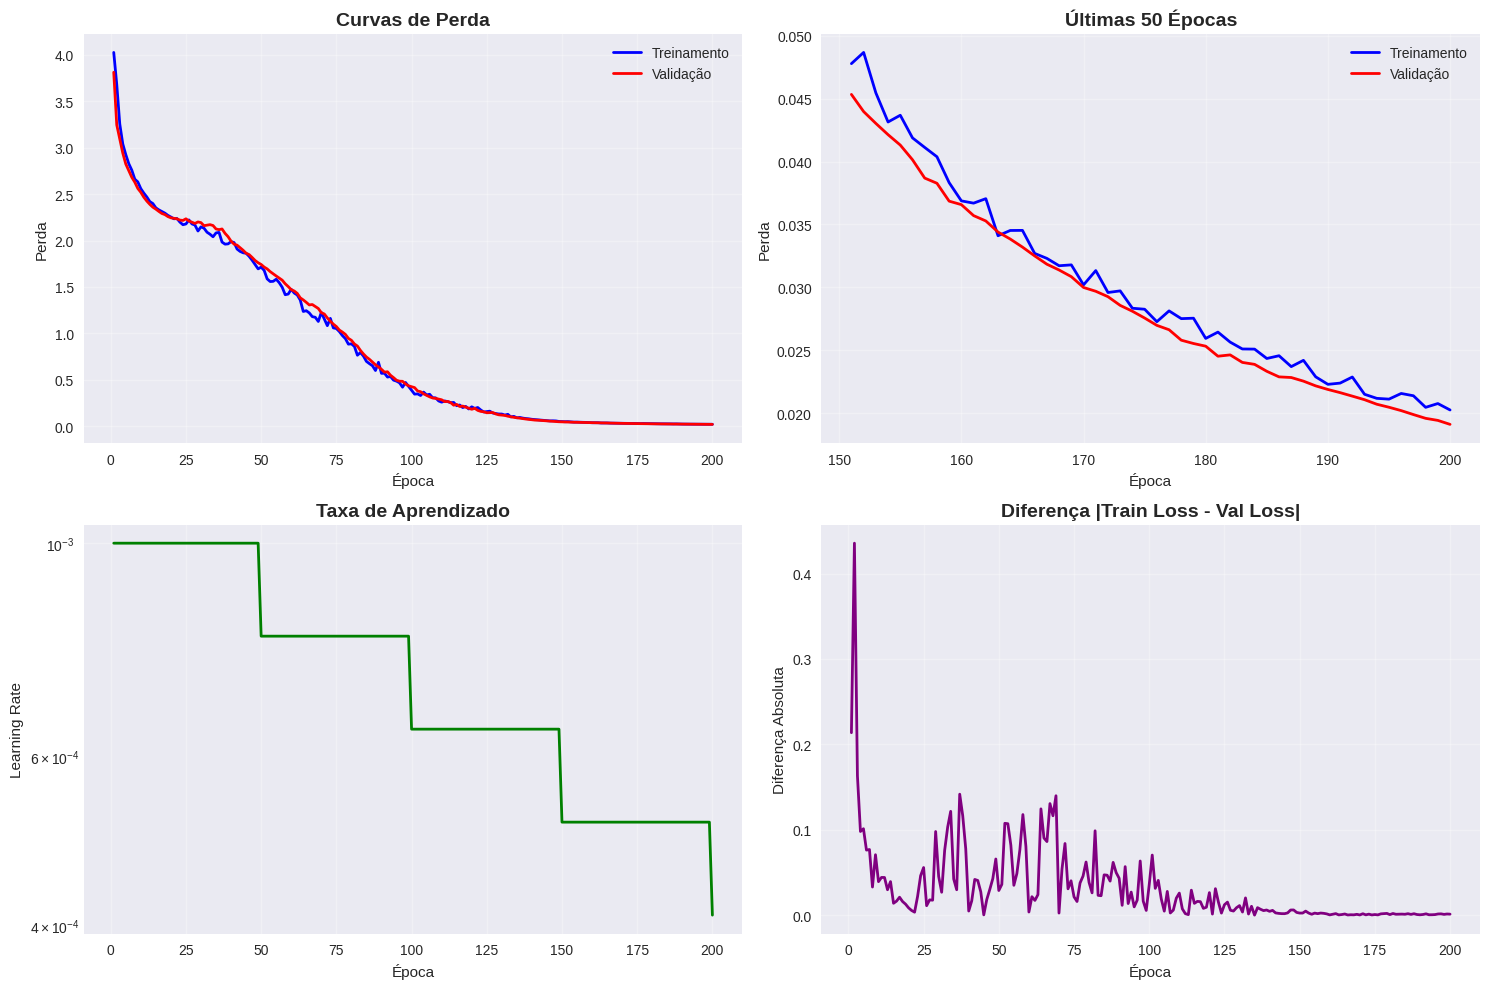

Estatísticas do Treinamento:
  Perda final de treinamento: 0.0203
  Perda final de validação: 0.0191
  Melhor perda de validação: 0.0191
  Redução da perda: 99.5%
  Taxa de aprendizado final: 4.10e-04


In [13]:
# Plotar métricas de treinamento
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(train_losses) + 1)

# Curvas de perda
axes[0, 0].plot(epochs, train_losses, 'b-', label='Treinamento', linewidth=2)
axes[0, 0].plot(epochs, val_losses, 'r-', label='Validação', linewidth=2)
axes[0, 0].set_title('Curvas de Perda', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Perda')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Últimas 50 épocas
if len(train_losses) > 50:
    start_idx = -50
    recent_epochs = epochs[start_idx:]
    axes[0, 1].plot(recent_epochs, train_losses[start_idx:], 'b-', label='Treinamento', linewidth=2)
    axes[0, 1].plot(recent_epochs, val_losses[start_idx:], 'r-', label='Validação', linewidth=2)
    axes[0, 1].set_title('Últimas 50 Épocas', fontweight='bold', fontsize=14)
else:
    axes[0, 1].plot(epochs, train_losses, 'b-', label='Treinamento', linewidth=2)
    axes[0, 1].plot(epochs, val_losses, 'r-', label='Validação', linewidth=2)
    axes[0, 1].set_title('Curvas de Perda (Zoom)', fontweight='bold', fontsize=14)

axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Perda')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Taxa de aprendizado
axes[1, 0].plot(epochs, learning_rates, 'g-', linewidth=2)
axes[1, 0].set_title('Taxa de Aprendizado', fontweight='bold', fontsize=14)
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Diferença entre train e val loss
loss_diff = [abs(t - v) for t, v in zip(train_losses, val_losses)]
axes[1, 1].plot(epochs, loss_diff, 'purple', linewidth=2)
axes[1, 1].set_title('Diferença |Train Loss - Val Loss|', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Diferença Absoluta')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas finais
print(f'Estatísticas do Treinamento:')
print(f'  Perda final de treinamento: {train_losses[-1]:.4f}')
print(f'  Perda final de validação: {val_losses[-1]:.4f}')
print(f'  Melhor perda de validação: {min(val_losses):.4f}')
print(f'  Redução da perda: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%')
print(f'  Taxa de aprendizado final: {learning_rates[-1]:.2e}')

## 10. Avaliação

In [14]:
def translate_sentence(model, sentence, pt_vocab, en_vocab, device, max_length=15):
    """Traduz uma frase do português para o inglês"""
    model.eval()

    with torch.no_grad():
        # Preprocessar entrada
        tokens = pt_vocab.sentence_to_indices(sentence.strip().lower())

        # Truncar se necessário
        if len(tokens) > max_length:
            tokens = tokens[:max_length]

        # Padding
        tokens_padded = tokens + [pt_vocab.word2idx['<PAD>']] * (max_length - len(tokens))
        source = torch.tensor(tokens_padded).unsqueeze(0).to(device)  # (1, max_length)

        # Traduzir usando o modelo
        translation_indices = model.translate(
            source,
            max_length=max_length,
            sos_token=en_vocab.word2idx['<SOS>'],
            eos_token=en_vocab.word2idx['<EOS>']
        )

        # Converter índices de volta para palavras
        translation_indices = translation_indices.squeeze(0).cpu().numpy()
        translated_words = []

        for idx in translation_indices:
            word = en_vocab.idx2word[idx]
            if word == '<EOS>':
                break
            if word != '<PAD>':
                translated_words.append(word)

        return ' '.join(translated_words)

# Testar traduções no conjunto de treinamento
print('=== TESTE DE TRADUÇÕES (CONJUNTO DE TREINAMENTO) ===')
print('Format: PT → Predição | Ground Truth')
print()

test_indices = [0, 1, 2, 3, 4, 10, 15, 20]  # Alguns exemplos específicos

for i in test_indices:
    if i < len(translation_pairs):
        pt_sentence, en_ground_truth = translation_pairs[i]
        prediction = translate_sentence(model, pt_sentence, pt_vocab, en_vocab, device)

        # Verificar se a tradução está correta
        is_correct = prediction.strip().lower() == en_ground_truth.strip().lower()
        status = "✓" if is_correct else "✗"

        print(f'"{pt_sentence}" → "{prediction}" | "{en_ground_truth}"')
        print()

=== TESTE DE TRADUÇÕES (CONJUNTO DE TREINAMENTO) ===
Format: PT → Predição | Ground Truth

"eu sou estudante" → "am student" | "i am student"

"ele gosta de livros" → "likes books" | "he likes books"

"ela come uma maçã" → "eats an apple" | "she eats an apple"

"nós vamos à escola" → "go to school" | "we go to school"

"eles têm um carro" → "have a car" | "they have a car"

"eles jogam futebol" → "play football" | "they play football"

"nós somos felizes" → "are happy" | "we are happy"

"ela vê um filme" → "watches a movie" | "she watches a movie"



In [15]:
# Teste com frases novas (fora do conjunto de treinamento)
print('=== TESTE COM FRASES NOVAS (GENERALIZAÇÃO) ===')
print()

new_sentences = [
    'ele está feliz',
    'ela gosta de música',
    'nós somos amigos',
    'eles estudam português',
    'você come bem'
]

expected_translations = [
    'he is happy',
    'she likes music',
    'we are friends',
    'they study portuguese',
    'you eat well'
]

print('Testando capacidade de generalização:')
for pt_sentence, expected in zip(new_sentences, expected_translations):
    prediction = translate_sentence(model, pt_sentence, pt_vocab, en_vocab, device)
    print(f'PT: "{pt_sentence}"')
    print(f'Predição: "{prediction}"')
    print(f'Esperado: "{expected}"')
    print()

=== TESTE COM FRASES NOVAS (GENERALIZAÇÃO) ===

Testando capacidade de generalização:
PT: "ele está feliz"
Predição: "make food"
Esperado: "he is happy"

PT: "ela gosta de música"
Predição: "eats an apple"
Esperado: "she likes music"

PT: "nós somos amigos"
Predição: "are happy"
Esperado: "we are friends"

PT: "eles estudam português"
Predição: "am student"
Esperado: "they study portuguese"

PT: "você come bem"
Predição: "speak portuguese"
Esperado: "you eat well"

